In [1]:
import evo
import numpy as np
from matplotlib.pyplot import figure, show, subplots
from matplotlib import pyplot as plt
import pandas as pd
import csv
from labellines import *
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib.lines import Line2D
#import yaml
from ruamel.yaml import YAML
yaml = YAML()
yaml.preserve_quotes = True  # Keep quotes if they exist
yaml.indent(mapping=2, sequence=4, offset=2)  # Preserve indentation
# yaml.default_flow_style = False  # Keep standard formatting
# yaml.allow_unicode = True
# yaml.explicit_start = False
yaml.representer.add_representer(
    float, lambda dumper, data: dumper.represent_scalar("tag:yaml.org,2002:float", str(data))
)

# Only fo2 dependent

In [66]:
# single run
evo.run_evo("input/chem.yaml", "Error_reports/env_error4.yaml", "input/output.yaml", folder="/Users/users/borgmann/Documents/masterproject/scripts/EVo")

Reading in from:
Chemistry file: input/chem.yaml
Environment file: Error_reports/env_error4.yaml
Output file: input/output.yaml 

Set parameters:
COMPOSITION = basalt
RUN_TYPE = closed
SINGLE_STEP = False
FIND_SATURATION = False
GAS_SYS = COHSN
FE_SYSTEM = True
OCS = False
S_SAT_WARN = False
T_START = 1473.15
P_START = 3000.0
P_STOP = 1.0
DP_MIN = 0.001
DP_MAX = 100.0
MASS = 100.0
WgT = 1e-05
LOSS_FRAC = 0.9999
DENSITY_MODEL = spera2000
FO2_MODEL = kc1991
FMQ_MODEL = frost1991
H2O_MODEL = burguisser2015
H2_MODEL = gaillard2003
C_MODEL = eguchi2018
CO_MODEL = armstrong2015
CH4_MODEL = ardia2013
SULFIDE_CAPACITY = oneill2020
SULFATE_CAPACITY = nash2019
SCSS = liu2007
N_MODEL = libourel2003
FO2_buffer_SET = True
FO2_buffer = IW
FO2_buffer_START = -5.0
FO2_SET = True
FO2_START = 8.3777516486972e-12
FH2_SET = False
FH2_START = 0.24
FH2O_SET = False
FH2O_START = 1000.0
FCO2_SET = False
FCO2_START = 1.0
ATOMIC_MASS_SET = True
ATOMIC_H = 600.0
ATOMIC_C = 200.0
ATOMIC_S = 4000.0
ATOMIC_N = 10.0

ValueError: Gas weight fraction is negative.

In [51]:
data = []
c = 0

truetitles = ['H2O', 'H2', 'O2', 'CO2', 'CO', 'CH4', 'SO2', 'H2S', 'S2', 'N2']


fo2_range = np.linspace(-4,4,20)
for i in fo2_range:
    c += 1
    print(c)
    
    # Load YAML file
    with open("input/env.yaml", "r") as file:
        config = yaml.load(file) or {}

    # Modify a specific value (example: changing `database.host`)
    config["FO2_buffer_START"] = float(i)
    config["ATOMIC_H"] = 100

    # Write back to YAML file
    with open("input/env.yaml", "w") as file:
        yaml.dump(config, file)

    evo.run_evo("input/chem.yaml", "input/env.yaml", "input/output.yaml", folder="/Users/users/borgmann/Documents/masterproject/scripts/EVo")
    data.append(np.genfromtxt('dgs_output_basalt_COHSN_closed_1473K.csv',skip_header=1,delimiter=',')[-1][9:19])
data = np.array(data)

1
Reading in from:
Chemistry file: input/chem.yaml
Environment file: input/env.yaml
Output file: input/output.yaml 

Set parameters:
COMPOSITION = basalt
RUN_TYPE = closed
SINGLE_STEP = False
FIND_SATURATION = False
GAS_SYS = COHSN
FE_SYSTEM = True
OCS = False
S_SAT_WARN = False
T_START = 1473.15
P_START = 3000.0
P_STOP = 1.0
DP_MIN = 0.001
DP_MAX = 100.0
MASS = 100.0
WgT = 1e-05
LOSS_FRAC = 0.9999
DENSITY_MODEL = spera2000
FO2_MODEL = kc1991
FMQ_MODEL = frost1991
H2O_MODEL = burguisser2015
H2_MODEL = gaillard2003
C_MODEL = eguchi2018
CO_MODEL = armstrong2015
CH4_MODEL = ardia2013
SULFIDE_CAPACITY = oneill2020
SULFATE_CAPACITY = nash2019
SCSS = liu2007
N_MODEL = libourel2003
FO2_buffer_SET = True
FO2_buffer = IW
FO2_buffer_START = -4.0
FO2_SET = True
FO2_START = 8.3777516486972e-12
FH2_SET = False
FH2_START = 0.24
FH2O_SET = False
FH2O_START = 1000.0
FCO2_SET = False
FCO2_START = 1.0
ATOMIC_MASS_SET = True
ATOMIC_H = 100.0
ATOMIC_C = 200.0
ATOMIC_S = 4000.0
ATOMIC_N = 10.0
WTH2O_SET = 

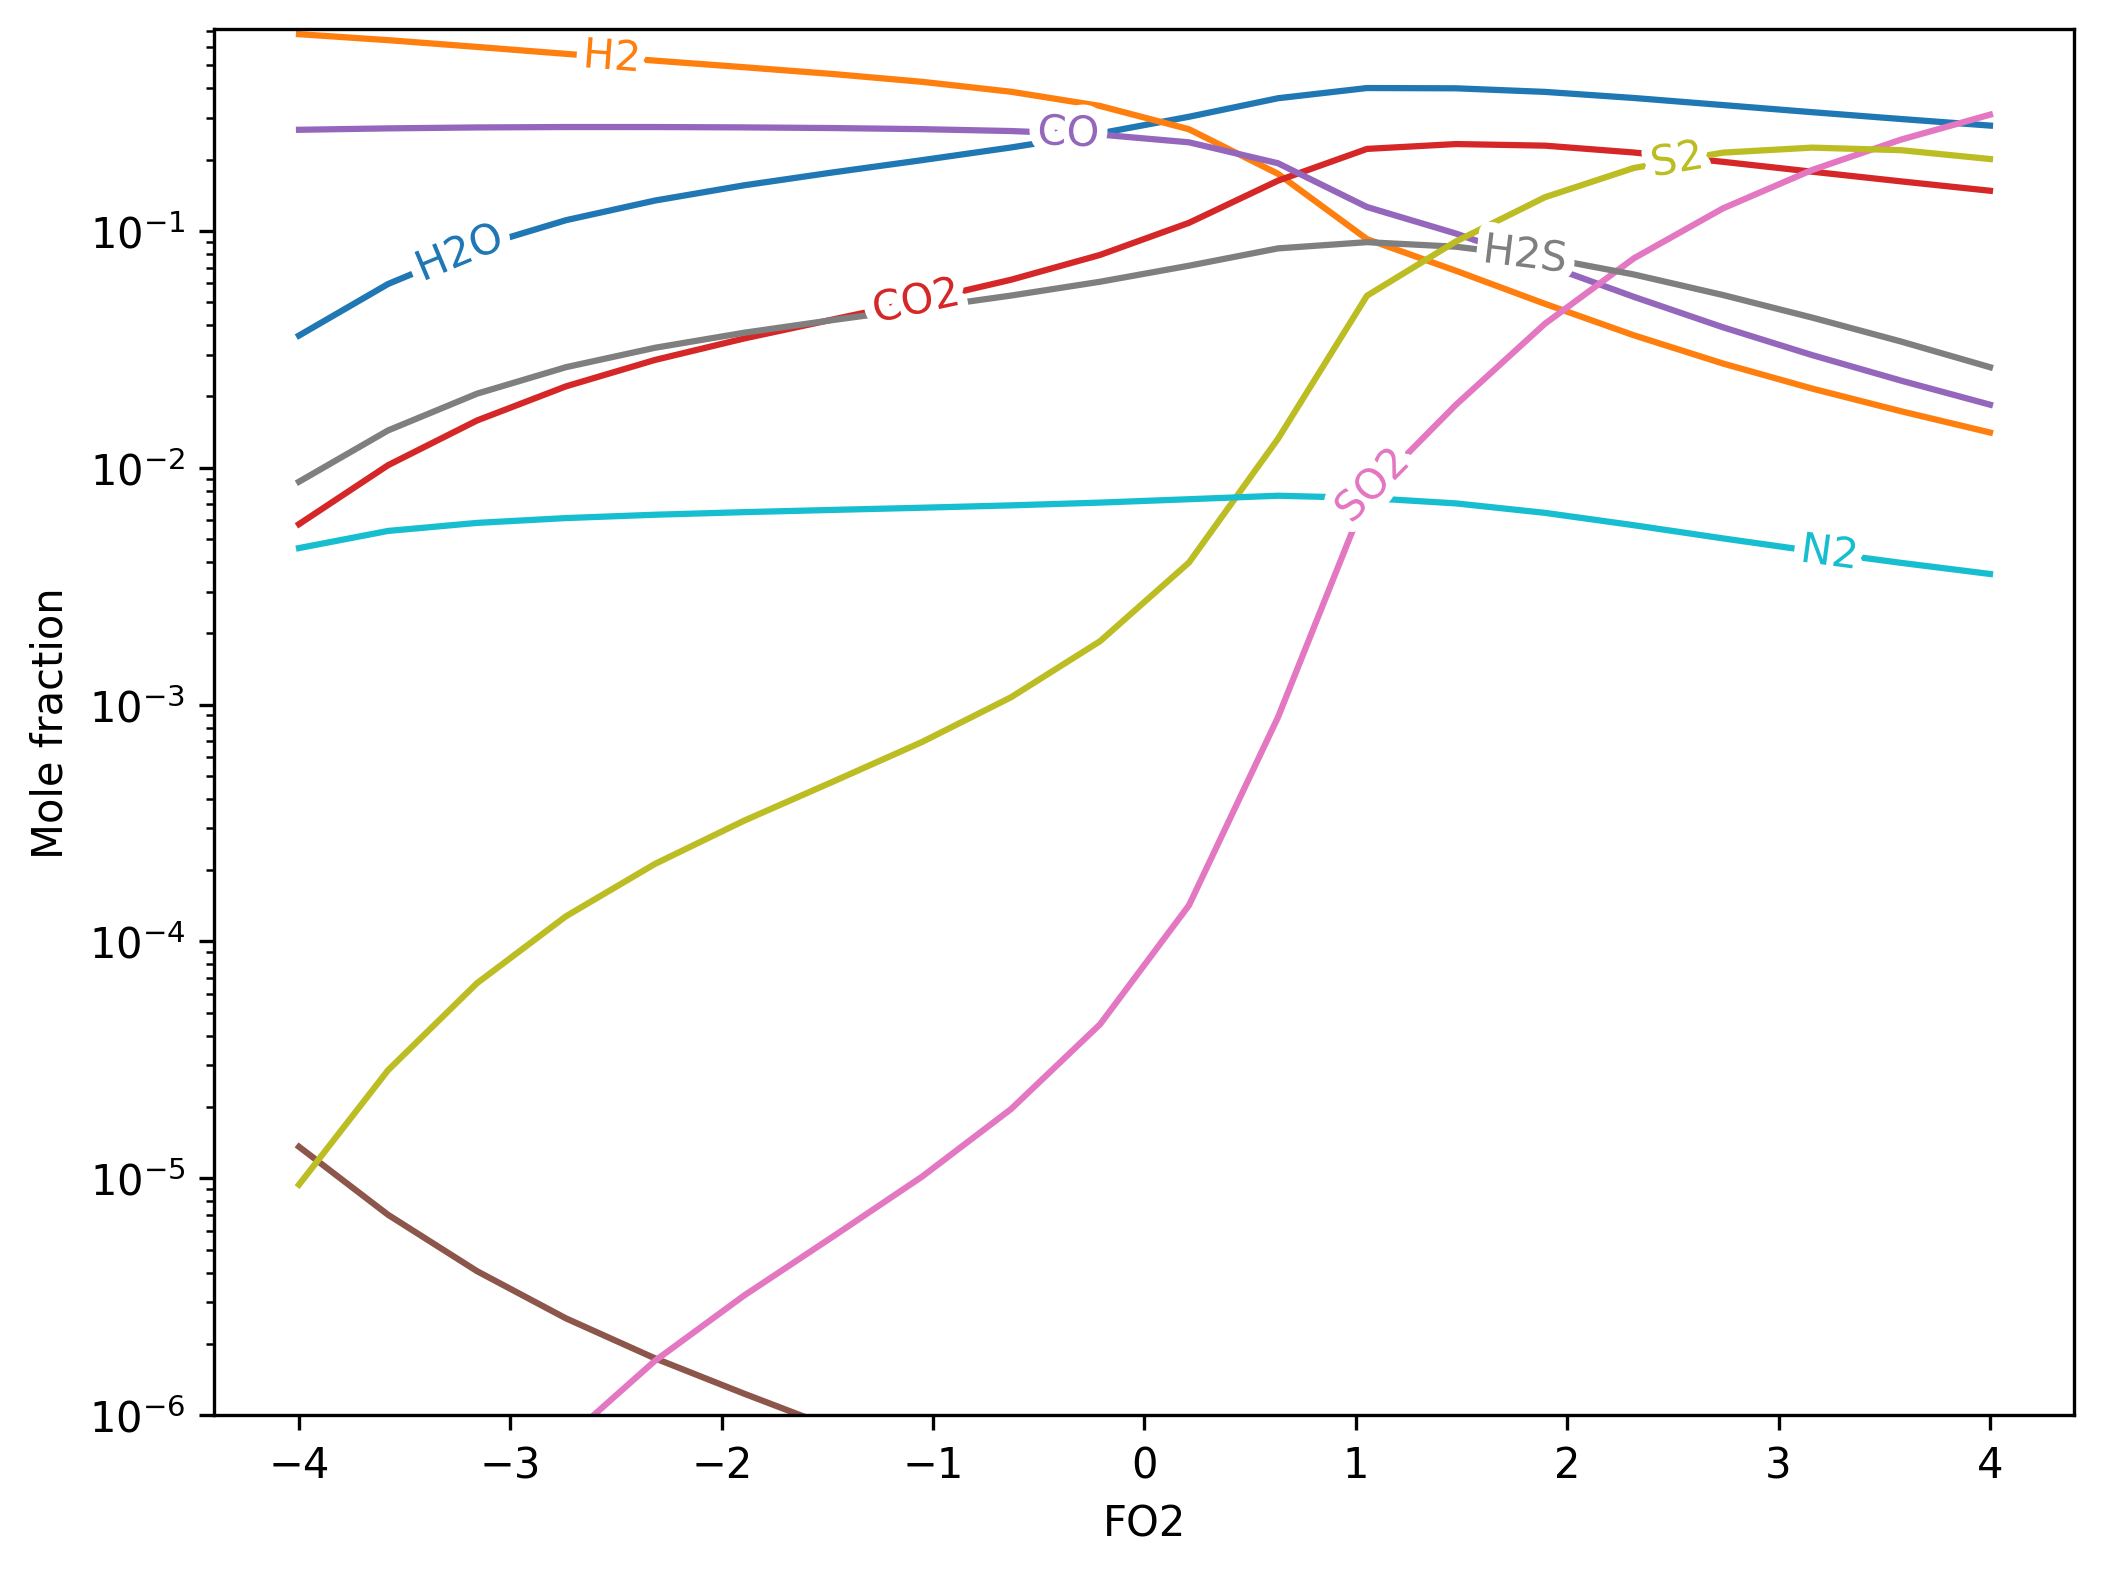

In [52]:
fig = figure(figsize=(8,6))
frame1 = fig.add_subplot(1,1,1)
for i in range(len(truetitles)):
    frame1.plot(fo2_range,data[:,i],label=truetitles[i])
frame1.set_xlabel('FO2')
frame1.set_ylabel('Mole fraction')
frame1.set_ylim(1E-6)
frame1.set_yscale('log')
labelLines(plt.gca().get_lines())
show()

# fo2 and C/H dependent

In [73]:
data_mole = []
data_weight = []
c = 0

truetitles = ['H2O', 'H2', 'O2', 'CO2', 'CO', 'CH4', 'SO2', 'H2S', 'S2', 'N2']


fo2_range = np.linspace(-4,4,10)
H_range = np.linspace(100,600,10)
HC_ratios = H_range/200
for i in fo2_range:
    for j in H_range:
        c += 1
        print(c)

        # Load YAML file
        with open("input/env.yaml", "r") as file:
            config = yaml.load(file) or {}

        # Modify a specific value (example: changing `database.host`)
        config["FO2_buffer_START"] = float(i)
        config["ATOMIC_H"] = float(j)

        # Write back to YAML file
        with open("input/env.yaml", "w") as file:
            yaml.dump(config, file)

        evo.run_evo("input/chem.yaml", "input/env.yaml", "input/output.yaml", folder="/Users/users/borgmann/Documents/masterproject/scripts/EVo")
        data_mole.append(np.genfromtxt('dgs_output_basalt_COHSN_closed_1473K.csv',skip_header=1,delimiter=',')[-1][9:19])
        data_weight.append(np.genfromtxt('dgs_output_basalt_COHSN_closed_1473K.csv',skip_header=1,delimiter=',')[-1][19:29])
data_mole = np.array(data_mole)
data_weight = np.array(data_weight)

1
Reading in from:
Chemistry file: input/chem.yaml
Environment file: input/env.yaml
Output file: input/output.yaml 

Set parameters:
COMPOSITION = basalt
RUN_TYPE = closed
SINGLE_STEP = False
FIND_SATURATION = False
GAS_SYS = COHSN
FE_SYSTEM = True
OCS = False
S_SAT_WARN = False
T_START = 1473.15
P_START = 3000.0
P_STOP = 1.0
DP_MIN = 0.001
DP_MAX = 100.0
MASS = 100.0
WgT = 1e-05
LOSS_FRAC = 0.9999
DENSITY_MODEL = spera2000
FO2_MODEL = kc1991
FMQ_MODEL = frost1991
H2O_MODEL = burguisser2015
H2_MODEL = gaillard2003
C_MODEL = eguchi2018
CO_MODEL = armstrong2015
CH4_MODEL = ardia2013
SULFIDE_CAPACITY = oneill2020
SULFATE_CAPACITY = nash2019
SCSS = liu2007
N_MODEL = libourel2003
FO2_buffer_SET = True
FO2_buffer = IW
FO2_buffer_START = -4.0
FO2_SET = True
FO2_START = 8.3777516486972e-12
FH2_SET = False
FH2_START = 0.24
FH2O_SET = False
FH2O_START = 1000.0
FCO2_SET = False
FCO2_START = 1.0
ATOMIC_MASS_SET = True
ATOMIC_H = 100.0
ATOMIC_C = 200.0
ATOMIC_S = 4000.0
ATOMIC_N = 10.0
WTH2O_SET = 

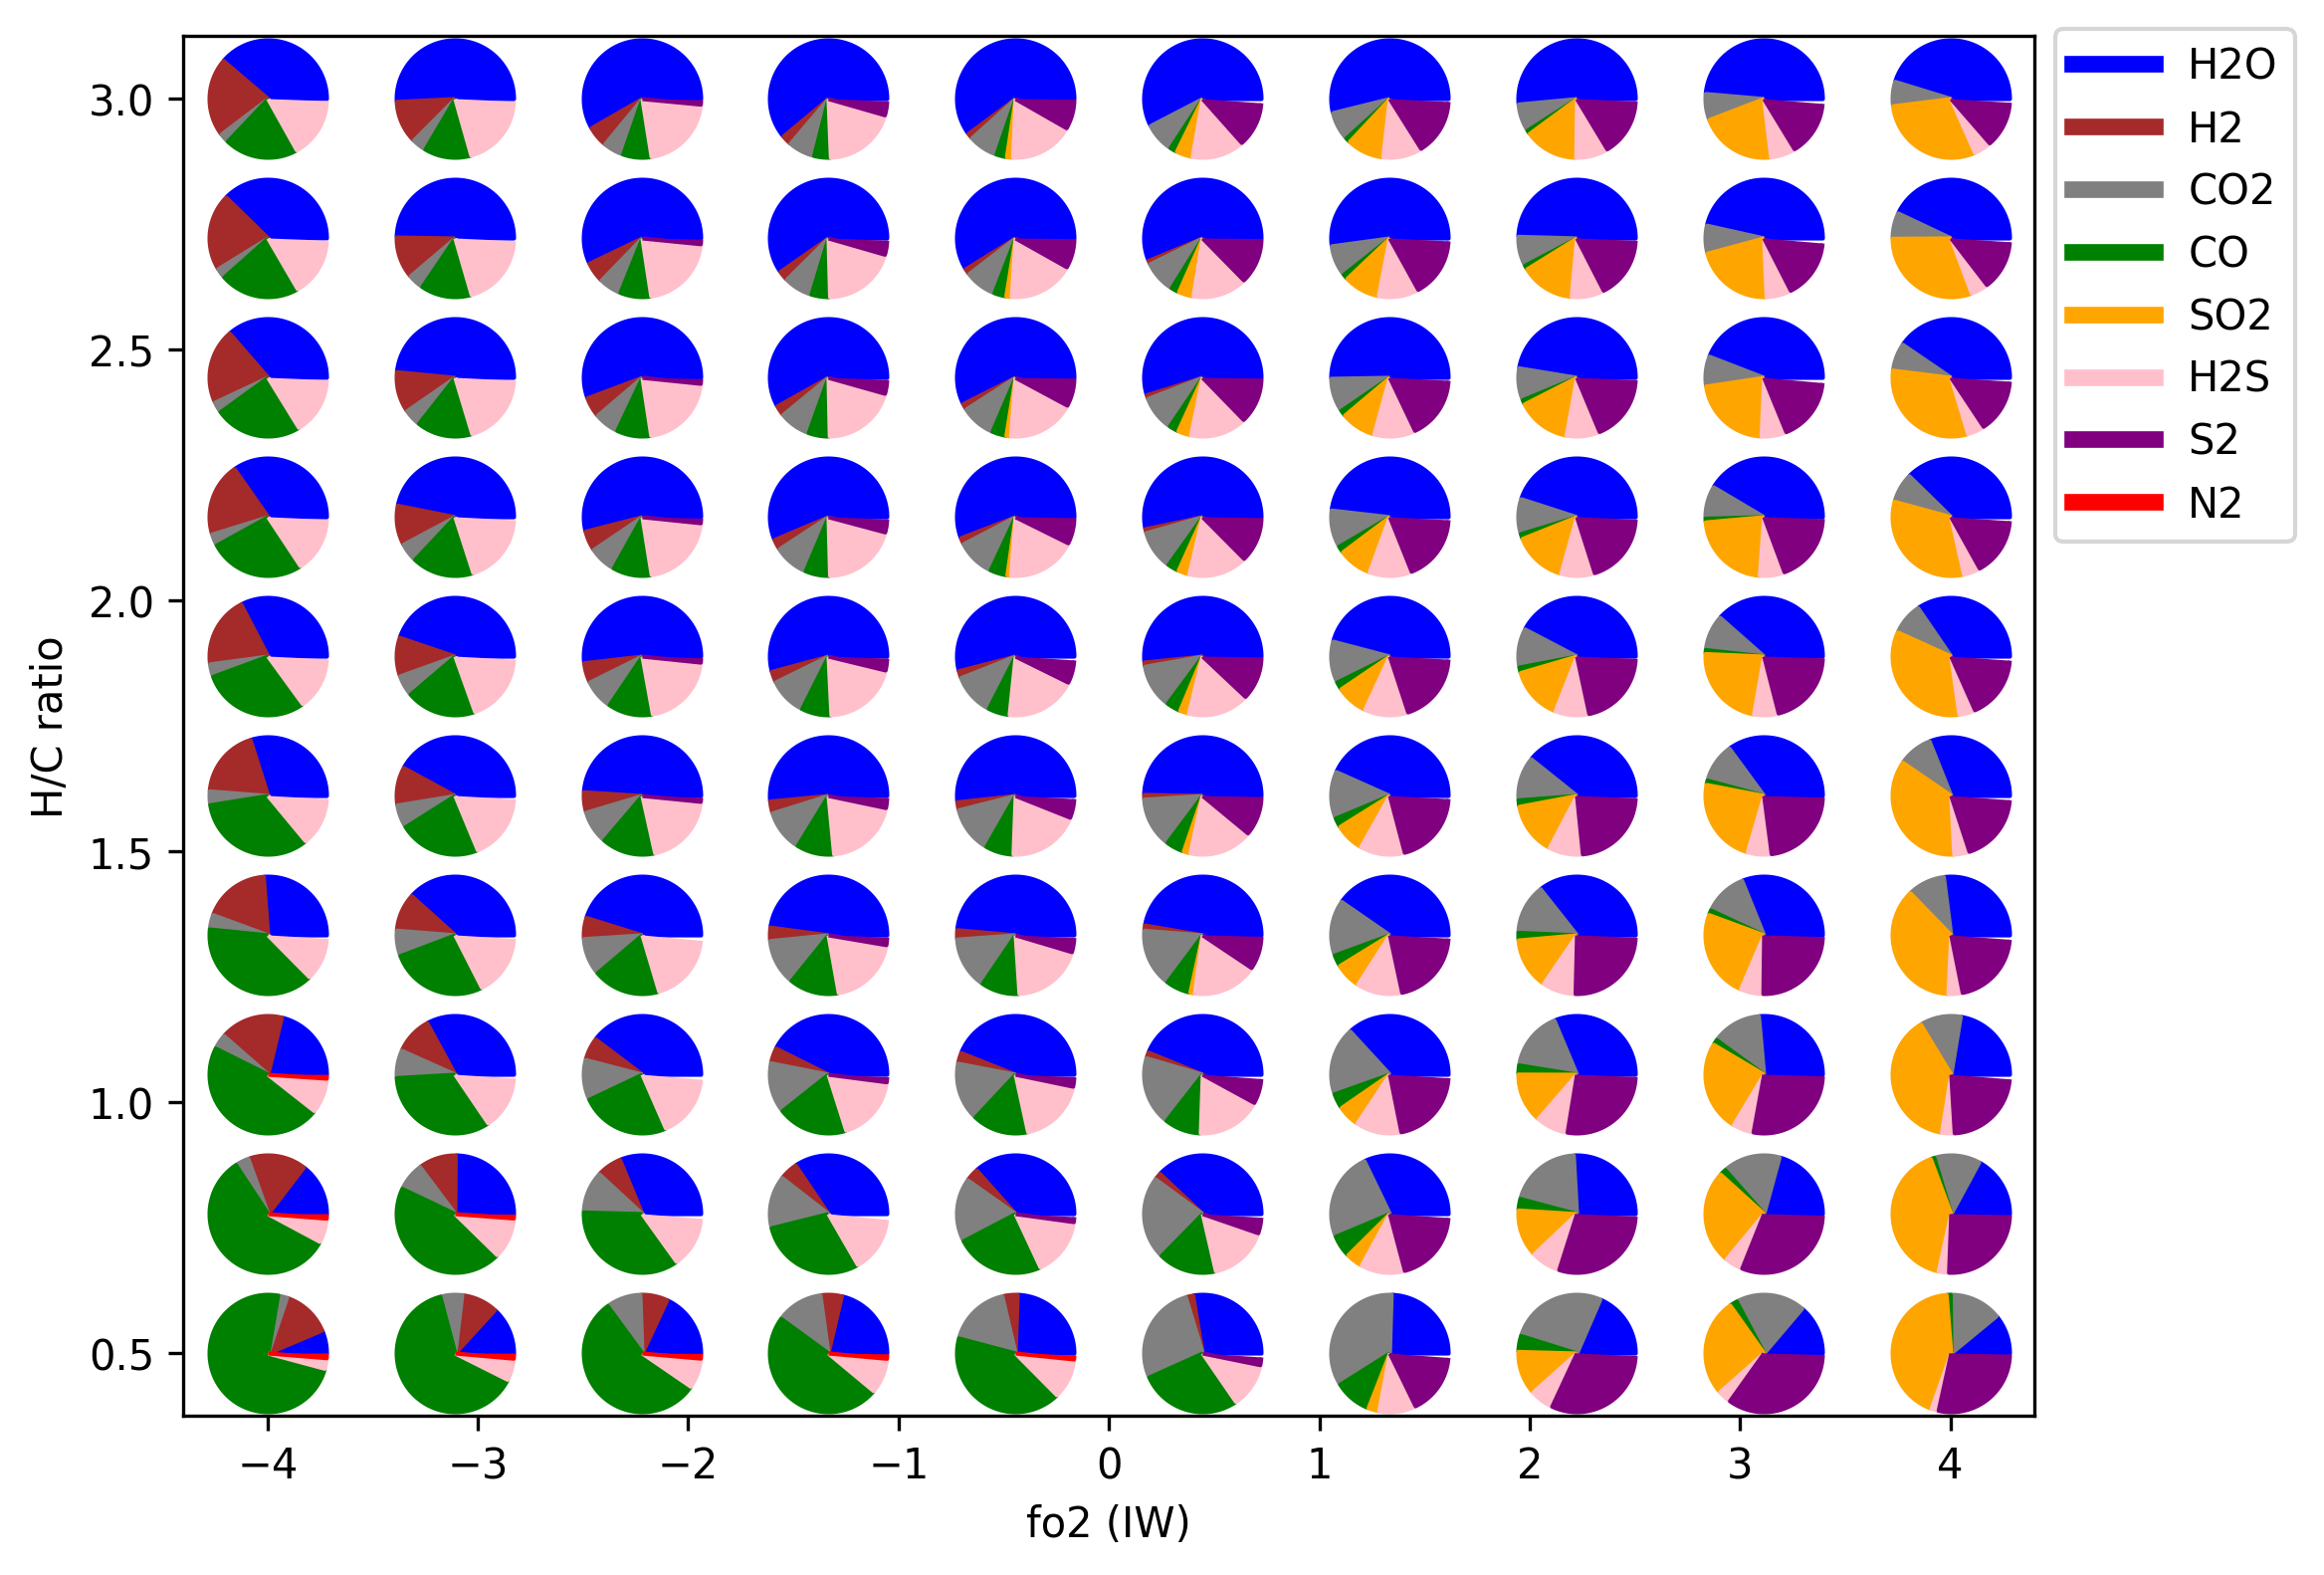

In [75]:
data = data_weight

small_numbers_cutoff = 0.01
truetitles = ['H2O', 'H2', 'O2', 'CO2', 'CO', 'CH4', 'SO2', 'H2S', 'S2', 'N2']
truecolors = ["blue","brown","cyan","gray","green","olive","orange","pink","purple","red"]
colors_used = []

# get fo2, H coordinates:
coords = []
for i in fo2_range:
    for j in HC_ratios:
        coords.append([i,j])

# start plot
fig = figure(figsize=(8,6))
frame1 = fig.add_subplot(1,1,1)

def remove_small_values(ratios):
    def filter_func(x):
        if x < small_numbers_cutoff:
            return False
        else:
            return True
    return np.array(list(filter(filter_func,ratios)))

for entry in range(len(data)):

    # find ratios of each molecule in the atmosphere
    ratios = []
    for i in range(len(data[entry])):
        ratios.append(data[entry][i]/sum(data[entry]))

    # remove small values from the ratios; you can't see these in the pie chart anyway
    ratios_big = remove_small_values(ratios)

    # find which colors we'll be using now, since some entries will be removed in the previous step
    colors = truecolors.copy()
    color_indices = []
    for i in range(len(ratios)):
        if ratios[i] < small_numbers_cutoff:
            color_indices.append(i)
    for i in sorted(color_indices, reverse=True):
        del colors[i]

    # add the used colors to a set, to know which ones to include in the legend at the end.
    for i in colors:
        colors_used.append(i)

    # make the ratios cumulative, this is needed for the pie charts
    ratios_cumulative = []
    for i in range(len(ratios_big)):
        ratios_cumulative.append(sum(ratios_big[:i+1]))

    # define the pie chart
    circles = []
    for i in range(len(ratios_cumulative)):
        if i == 0:
            x = [0] + np.cos(np.linspace(0, 2 * np.pi * ratios_cumulative[i], 100)).tolist()
            y = [0] + np.sin(np.linspace(0, 2 * np.pi * ratios_cumulative[i], 100)).tolist()
            xy = np.column_stack([x, y])
            circles.append(xy)
        else:
            x = [0] + np.cos(np.linspace(2 * np.pi * ratios_cumulative[i-1], 2 * np.pi * ratios_cumulative[i], 100)).tolist()
            y = [0] + np.sin(np.linspace(2 * np.pi * ratios_cumulative[i-1], 2 * np.pi * ratios_cumulative[i], 100)).tolist()
            xy = np.column_stack([x, y])
            circles.append(xy)

    # plot
    for i in range(len(ratios_cumulative)):
        frame1.scatter(coords[entry][0], coords[entry][1], marker=circles[i], s=800*(np.abs(circles[i]).max())**2, facecolor=colors[i])

# make custom index
colors_used = sorted(list(dict.fromkeys(colors_used)))

custom_lines = []
custom_labels = []

colors = colors = truecolors.copy()
for i in colors_used:
    index = [item==i for item in colors]
    custom_lines.append(Line2D([0], [0], color=np.array(colors)[index][0], lw=4))
    custom_labels.append(np.array(truetitles)[index][0])

frame1.legend(custom_lines,custom_labels,bbox_to_anchor=(1, 1.02))
frame1.set_xlabel("fo2 (IW)")
frame1.set_ylabel("H/C ratio")
plt.show()